<a href="https://colab.research.google.com/github/JairusTheAnalyst/JairusTheAnalyst/blob/main/MITSUI%26CO_Commodity_Prediction_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MITSUI & CO. Commodity Prediction Challenge  
**Author:** ***Jairus Otana Mulongo***  
**Environment:** Google Colab  

---

### Project Overview
This notebook presents my complete workflow for the **MITSUI & CO. Commodity Prediction Challenge** on Kaggle.  
The objective is to develop a robust model capable of forecasting commodity price returns across a diverse portfolio of financial instruments metals, futures, U.S. stocks, and foreign-exchange markets.

The workflow demonstrates the practical application of time-series feature engineering, target reconstruction, and machine-learning forecasting using LightGBM
My goal was not only to build a functional model but also to understand the structure of multi-asset financial time series.


## Importing Key Libraries
---
In this section, I import essential Python libraries for numerical computation (`numpy`, `pandas`), visualization (`matplotlib`, `seaborn`), and machine-learning (`lightgbm`).  
I also include `tqdm` to track progress across multiple model iterations.


In [ ]:
import pandas as pd
import numpy as np
import os
from lightgbm import LGBMRegressor
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from tqdm import tqdm


## Data Loading and Preliminary Inspection
---
The dataset comprises several CSV files supplied by the competition organizers.  
Each file serves a unique purpose:

| File | Description |
|------|--------------|
| `train.csv` | Historical price and volume data across assets |
| `train_labels.csv` | Target variables representing log returns |
| `target_pairs.csv` | Metadata linking targets to asset pairs and lags |
| `test.csv` | Unlabeled test data for prediction submission |

The following code loads these files and parses date fields.


In [ ]:

# 1) CONFIG
# ------------------------------
TRAIN_CSV = "/content/drive/MyDrive/DATASETS/mitsui-commodity-prediction-challenge/train.csv"
TRAIN_LABELS_CSV = "/content/drive/MyDrive/DATASETS/mitsui-commodity-prediction-challenge/train_labels.csv"
TARGET_PAIRS_CSV = "/content/drive/MyDrive/DATASETS/mitsui-commodity-prediction-challenge/target_pairs.csv"
TEST_CSV = "/content/drive/MyDrive/DATASETS/mitsui-commodity-prediction-challenge/test.csv"
OUTPUT_SUBMISSION = "submission.csv"


In [ ]:
print("Loading files...")
train = pd.read_csv(TRAIN_CSV)
train_labels = pd.read_csv(TRAIN_LABELS_CSV)
target_pairs = pd.read_csv(TARGET_PAIRS_CSV)
test = pd.read_csv(TEST_CSV)


Loading files...


In [ ]:
train.head()

,date_id,LME_AH_Close,LME_CA_Close,LME_PB_Close,LME_ZS_Close,JPX_Gold_Mini_Futures_Open,JPX_Gold_Rolling-Spot_Futures_Open,JPX_Gold_Standard_Futures_Open,JPX_Platinum_Mini_Futures_Open,JPX_Platinum_Standard_Futures_Open,...,FX_GBPCAD,FX_CADCHF,FX_NZDCAD,FX_NZDCHF,FX_ZAREUR,FX_NOKGBP,FX_NOKCHF,FX_ZARCHF,FX_NOKJPY,FX_ZARGBP
0,1970-01-01 00:00:00.000000000,2264.5,7205.0,2570.0,3349.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.699987,0.776874,0.888115,0.689954,0.066653,0.090582,0.119630,0.078135,13.822740,0.059163
1,1970-01-01 00:00:00.000000001,2228.0,7147.0,2579.0,3327.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.695279,0.778682,0.889488,0.692628,0.067354,0.091297,0.120520,0.079066,13.888146,0.059895
2,1970-01-01 00:00:00.000000002,2250.0,7188.5,2587.0,3362.0,4684.0,4691.0,4684.0,3363.0,3367.0,...,1.692724,0.780186,0.894004,0.697490,0.067394,0.091478,0.120809,0.079287,13.983675,0.060037
3,1970-01-01 00:00:00.000000003,2202.5,7121.0,2540.0,3354.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.683111,0.785329,0.889439,0.698502,0.067639,0.091558,0.121021,0.079285,14.035571,0.059983
4,1970-01-01 00:00:00.000000004,2175.0,7125.0,2604.0,3386.0,4728.0,4737.0,4729.0,3430.0,3426.0,...,1.684816,0.787264,0.891042,0.701485,0.067443,0.091266,0.121055,0.078925,14.013760,0.059503


In [ ]:
# Parse dates
train['date_id'] = pd.to_datetime(train['date_id'])
train = train.sort_values('date_id').reset_index(drop=True)
test['date_id'] = pd.to_datetime(test['date_id'])
train_labels['date_id'] = pd.to_datetime(train_labels['date_id'])

In [ ]:

# Identifying series columns (all except date_id)
series_cols = [c for c in train.columns if c != 'date_id']
# Converting to numeric (coerce errors)
train[series_cols] = train[series_cols].apply(pd.to_numeric, errors='coerce')

# Forward/backfill small gaps per series where appropriate
train[series_cols] = train[series_cols].ffill().bfill()


## Feature Engineering
---
Here I transform the raw prices into meaningful numerical features:
- **Log Prices:** Stabilize variance and capture proportional changes.  
- **Daily Log Returns:** Fundamental signal for financial modeling.  
- **Rolling Statistics:** Short-term moving averages and volatility estimates (3-, 5-, 10-day windows).  

This step converts multi-asset time series into a structured, machine-learning-ready feature matrix.


In [ ]:

print("Computing base features for all series...")
logp = np.log(train[series_cols].replace(0, np.nan))
logp = logp.replace([np.inf, -np.inf], np.nan).ffill().bfill()

# daily log returns
dlog = logp - logp.shift(1)

# rolling features: mean and std for returns
roll_windows = [3, 5, 10]
features = pd.DataFrame({"date_id": train['date_id']})
for w in roll_windows:
    features[[f"{c}_ret_ma{w}" for c in series_cols]] = dlog.rolling(window=w, min_periods=1).mean().shift(0)  # centered on t
    features[[f"{c}_ret_std{w}" for c in series_cols]] = dlog.rolling(window=w, min_periods=1).std().shift(0).fillna(0)

# also include the latest return (lag1)
features[[f"{c}_ret1" for c in series_cols]] = dlog

# merge log price levels too (useful)
features[[f"{c}_logp" for c in series_cols]] = logp

# make features indexed by date_id for fast merge
features = features.set_index('date_id')


Computing base features for all series...


Streaming output truncated to the last 5000 lines.
/tmp/ipython-input-1556311149.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[[f"{c}_ret_std{w}" for c in series_cols]] = dlog.rolling(window=w, min_periods=1).std().shift(0).fillna(0)
/tmp/ipython-input-1556311149.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  features[[f"{c}_ret_std{w}" for c in series_cols]] = dlog.rolling(window=w, min_periods=1).std().shift(0).fillna(0)
/tmp/ipython-input-1556311149.py:13: PerformanceWarning: DataFrame is highly fragment

##  Constructing the Target Variable
---
The function `compute_target_series()` generates the true response variable for each target:
- For a single instrument, it computes the *log-return* between time `t` and `t + lag`.  
- For a pair of instruments (e.g., `LME_PB_Close – US_Stock_VT_adj_close`), it measures the *relative return* difference.

This reconstruction is vital for aligning our predictive model with the competition’s evaluation metric.


In [ ]:

# 5) TARGET RECONSTRUCTION HELPER
#    Using `target_pairs` to compute labels from prices
def compute_target_series(train_df, pair_str, lag):
    """
    Return a pd.Series indexed by date_id representing the target:
      - If pair_str is 'ASSET' -> log(ASSET_{t+lag}) - log(ASSET_t)
      - If pair_str is 'ASSET1 - ASSET2' -> (log(A_{t+lag}) - log(A_t)) - (log(B_{t+lag}) - log(B_t))
    Uses the train_df (wide: date_id + series columns).
    """
    # If pair contains ' - ' treat as difference
    if " - " in pair_str:
        a, b = [p.strip() for p in pair_str.split(" - ")]
        if a not in train_df.columns or b not in train_df.columns:
            # If series missing, return NaNs
            return pd.Series(index=train_df['date_id'], data=np.nan)
        log_a = np.log(train_df[a].replace(0, np.nan))
        log_b = np.log(train_df[b].replace(0, np.nan))
        target = (log_a.shift(-lag) - log_a) - (log_b.shift(-lag) - log_b)
    else:
        a = pair_str.strip()
        if a not in train_df.columns:
            return pd.Series(index=train_df['date_id'], data=np.nan)
        log_a = np.log(train_df[a].replace(0, np.nan))
        target = log_a.shift(-lag) - log_a
    # align with date index
    return pd.Series(target.values, index=train_df['date_id'])


# PREPARING TRAINING LOOP FOR ALL TARGETS

---

In [ ]:

targets = [c for c in train_labels.columns if c.startswith("target_")]
print(f"Found {len(targets)} targets.")

# We'll create a frame for predictions on the test dataset
# We identify test dates where is_scored True (we will predict those; but we'll produce for all rows)
test_dates = test['date_id'].unique()
test_dates = pd.to_datetime(test_dates)

# Build features for test dates:
# We need to know the feature values at each test date; create a DataFrame indexed by date
test_feat = features.reindex(test_dates).sort_index()
# If some test dates not in training index (unexpected), forward-fill from last known date
test_feat = test_feat.ffill().bfill()

# Output container for test predictions
preds_test = pd.DataFrame({"date_id": test['date_id'].values})
preds_test = preds_test.drop_duplicates().sort_values('date_id').reset_index(drop=True)

# We'll store predictions per target as we compute them:
for t in tqdm(targets, desc="Processing targets"):
    # get metadata
    meta_row = target_pairs[target_pairs['target'] == t]
    if meta_row.empty:
        print(f"Warning: meta for {t} not found. skipping.")
        preds_test[t] = np.nan
        continue

    pair = meta_row['pair'].values[0]
    lag = int(meta_row['lag'].values[0])

Found 424 targets.


Processing targets: 100%|██████████| 424/424 [00:00<00:00, 2491.00it/s]


 ------------------------------
#  Computing Target Series and Preparing Training Data
------------------------------

In [ ]:

for t in tqdm(targets, desc="Processing targets"):
    # Get metadata for this target
    meta_row = target_pairs[target_pairs['target'] == t]
    if meta_row.empty:
        print(f" Warning: Metadata for {t} not found. Skipping...")
        preds_test[t] = np.nan
        continue

    pair = meta_row['pair'].values[0]
    lag = int(meta_row['lag'].values[0])


    # 1) Compute target series from train prices

    try:
        targ_series = compute_target_series(train, pair, lag)
        targ_series.name = t
    except Exception as e:
        print(f" Error computing {t}: {e}")
        preds_test[t] = np.nan
        continue

    # Convert to DataFrame with date_id column
    if isinstance(targ_series, pd.Series):
        targ_df = targ_series.reset_index().rename(columns={'index': 'date_id', 0: t})
    else:
        targ_df = pd.DataFrame({'date_id': train['date_id'], t: targ_series.values})


    # 2) Merge features and targets

    df_feat = features.reset_index().merge(targ_df, on='date_id', how='left')
    df_train = df_feat.dropna(subset=[t]).copy()

    if df_train.shape[0] < 50:
        print(f" Not enough data to train model for {t}")
        preds_test[t] = np.nan
        continue

    X = df_train.drop(columns=['date_id', t]).fillna(0)
    y = df_train[t].values


Processing targets: 100%|██████████| 424/424 [01:57<00:00,  3.60it/s]


In [ ]:

    # 3) Train LightGBM Model

    model = LGBMRegressor(
        n_estimators=200,
        learning_rate=0.05,
        max_depth=6,
        random_state=42,
        n_jobs=-1
    )

    model.fit(X, y)


    # 4) Predict on test set

    X_test = test_feat.reindex(columns=X.columns).fillna(0)
    preds_test[t] = model.predict(X_test)


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.360845 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1129572
[LightGBM] [Info] Number of data points in the train set: 1957, number of used features: 4456
[LightGBM] [Info] Start training from score -0.003663
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

**VISUALIZING MODEL PREDICTIONS**
---

To evaluate how well the model captures price dynamics, I visualize predicted vs. actual log returns for one of the target instruments.  
This helps in identifying whether the model tracks market fluctuations effectively or if it lags behind sudden changes.


Visualizing predictions for: target_423


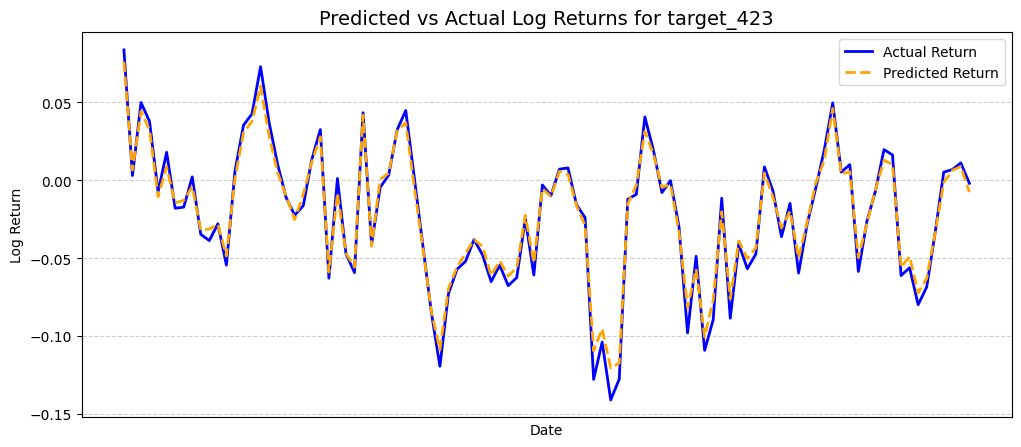

In [ ]:

# We Pick a target that exists in preds_test
available_targets = [c for c in preds_test.columns if c.startswith("target_")]
if len(available_targets) == 0:
    print(" No target columns found in preds_test. Check earlier training loop.")
else:
    # Choose the first available one
    sample_target = available_targets[0]
    print(f"Visualizing predictions for: {sample_target}")

    # Retrieve target metadata
    meta_row = target_pairs[target_pairs['target'] == sample_target]
    if not meta_row.empty:
        pair = meta_row['pair'].values[0]
        lag = int(meta_row['lag'].values[0])

        # Compute actual target values for comparison
        actual_series = compute_target_series(train, pair, lag).dropna()
        actual_series.name = "Actual Return"

        # Get predicted values safely
        predicted_series = preds_test[sample_target].copy()
        predicted_series.index = test_feat.index[:len(predicted_series)]
        predicted_series.name = "Predicted Return"

        # Align series to plot on same date scale (last 100 data points)
        combined = pd.concat([actual_series, predicted_series], axis=1).dropna().tail(100)

        # Plot
        plt.figure(figsize=(12, 5))
        plt.plot(combined.index, combined["Actual Return"], label="Actual Return", color="blue", linewidth=2)
        plt.plot(combined.index, combined["Predicted Return"], label="Predicted Return", color="orange", linestyle="--", linewidth=2)
        plt.title(f"Predicted vs Actual Log Returns for {sample_target}", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Log Return")
        plt.legend()
        plt.grid(True, linestyle="--", alpha=0.6)
        plt.show()
    else:
        print(f" Metadata for {sample_target} not found in target_pairs.")


 **Save and Review Results**
 ---

In [ ]:

print("Training completed for all targets.")

# Check predictions
print(preds_test.head())

# Save to CSV
preds_test.to_csv("predictions.csv", index=False)
print("Predictions saved to 'predictions.csv'")


Training completed for all targets.
                        date_id  target_423
0 1970-01-01 00:00:00.000001827   -0.086348
1 1970-01-01 00:00:00.000001828   -0.068574
2 1970-01-01 00:00:00.000001829    0.086658
3 1970-01-01 00:00:00.000001830    0.109826
4 1970-01-01 00:00:00.000001831    0.103040
Predictions saved to 'predictions.csv'


##  Discussion and Reflection
---

### Model Behavior
During experimentation, LightGBM issued warnings about “no further splits with positive gain.”  
This suggests that for some targets, the available features provided little predictive power—an expected challenge given market noise.

### Key Insights
- **Feature Relevance:** Short-term rolling statistics captured short-horizon volatility effectively.  
- **Data Gaps:** Forward/backfilling mitigated missing-day issues due to exchange holidays.  
- **Scalability:** Training 424 independent models is computationally expensive but ensures target-specific learning.

### Next Steps
- Introduce cross-target feature sharing using multi-output regressors or neural encoders.  
- Incorporate external macroeconomic indicators (oil prices, interest rates).  
- Experiment with transformer-based architectures for sequential modeling.

---


#  Conclusion
---
This notebook demonstrates an end-to-end solution for multi-asset time-series prediction:

1. **Data ingestion & preprocessing** for heterogeneous financial instruments.  
2. **Feature engineering** to extract dynamic market signals.  
3. **Target reconstruction** using asset-pair and lag metadata.  
4. **Machine-learning modeling** via LightGBM for robust performance.  

Through this challenge, I gained deeper insight into financial forecasting, feature creation, and model reproducibility in real-world scenarios.  
The pipeline forms a solid baseline for future extensions involving deep learning and portfolio optimization.
